# Purpose
This repo contains a notebook that analyzes Illumina 450k whole-blood DNA methylation from GSE42861 to test how Rheumatoid Arthritis (RA) relates to genome-wide methylation.

Using Biolearn's DataLibrary, methylation beta values and metadata are loaded and then aligned for the following analysis:

1) **RA association (EWAS):** Ordinary Least Squares (OLS) models: beta ~ RA + age + sex, to identify CpGs differentially methylated in RA
2) **Differential variability (DV):** Brown–Forsythe tests to find CpGs with altered methylation variance

# Visualization

For visualization CpG was mapped to chromosome/position for creating genome-wide Manhattan plots:
- RA association Manhattan: –log10(p_RA) across the genome
![RA vs. Normal p-tests](assets/RA_vs_NonRA.png)
- DV Manhattan: –log10(p_DV) for variance differences
![DV RA vs. Normal p-tests](assets/DVRA_vs_NonRA.png)



# Interpretation
Top RA-associated loci include SMARCA4 and KLF2 (chr19, chromatin remodeling and immune regulation), S1PR1 (chr1, lymphocyte trafficking), and PTPRCAP/LY9 (immune signaling). DV analysis shows additional immune-pathway CpGs with genes like MRGPRG, FAM113B, and MICA, suggesting RA-related epigenetic instability.

## Data Loading & Preprocessing

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm
from biolearn.data_library import DataLibrary
from biolearn.util import cached_download

In [2]:
library = DataLibrary()
src = library.get("GSE42861")
geo = src.load()

In [3]:
meta = geo.metadata.copy()
beta = geo.dnam.copy()

print(f"beta shape (CpG x samples): {beta.shape}")
print(f"metadata shape (samples x fields): {meta.shape}")

common_ids = meta.index.intersection(beta.columns)
beta = beta[common_ids]
meta = meta.loc[common_ids]
print(f"aligned samples: {len(common_ids)}")

beta shape (CpG x samples): (485577, 689)
metadata shape (samples x fields): (689, 4)
aligned samples: 689


In [4]:
meta["RA"] = (meta["disease"].str.lower().str.contains("rheumatoid")).astype(
    int
)
meta["age"] = pd.to_numeric(meta["age"], errors="coerce")
meta["sex"] = pd.to_numeric(meta["sex"], errors="coerce")

X = sm.add_constant(meta[["RA", "age", "sex"]])

print(X.head())
print("-" * 50)
print(meta["RA"].value_counts())

            const  RA   age  sex
GSM1051525    1.0   1  67.0    1
GSM1051526    1.0   1  49.0    1
GSM1051527    1.0   1  53.0    1
GSM1051528    1.0   1  62.0    1
GSM1051529    1.0   1  33.0    1
--------------------------------------------------
RA
1    354
0    335
Name: count, dtype: int64


## OLS and Brown-Forsythe Tests

In [5]:
def per_cpg_ols_p_RA(beta_row):
    y = beta_row.values.astype(float)
    if np.var(y) < 1e-8:
        return np.nan
    try:
        res = sm.OLS(y, X.values, missing="drop").fit()
        return res.pvalues[list(X.columns).index("RA")]
    except Exception:
        return np.nan


p_RA = []
for cpg, row in beta.iterrows():
    p_RA.append(per_cpg_ols_p_RA(row.loc[X.index]))

assoc = pd.DataFrame({"CpG": beta.index, "p_RA": p_RA}).dropna()

# Multiple testing correction using Benjamini–Hochberg FDR (there's lots of tests -> BH instead of Bonferroni)
assoc["q_RA"] = multipletests(assoc["p_RA"], method="fdr_bh")[1]
assoc.head()

,CpG,p_RA,q_RA
0,cg00000029,4.574712e-09,3.076356e-08
1,cg00000108,2.438033e-05,7.269724e-05
2,cg00000109,3.711316e-03,7.001825e-03
3,cg00000165,2.626376e-01,3.238581e-01
4,cg00000236,1.454979e-15,2.879812e-14


In [6]:
groups = meta.loc[X.index, "RA"].values.astype(int)

def brown_forsythe(values, groups01):
    """
    Brown–Forsythe test for equal variances between two groups.
    """
    g0 = values[groups01 == 0]
    g1 = values[groups01 == 1]
    if np.sum(~np.isnan(g0)) < 10 or np.sum(~np.isnan(g1)) < 10:
        return np.nan
    w, p = stats.levene(g0, g1, center="median")
    return p

p_DV = []
for cpg, row in beta.iterrows():
    p_DV.append(brown_forsythe(row.loc[X.index].values, groups))

dv = pd.DataFrame({"CpG": beta.index, "p_DV": p_DV}).dropna()
dv["q_DV"] = multipletests(dv["p_DV"], method="fdr_bh")[1]
dv.head()

,CpG,p_DV,q_DV
0,cg00000029,0.033058,0.237189
1,cg00000108,0.453729,0.760920
2,cg00000109,0.773045,0.923102
3,cg00000165,0.705850,0.895251
4,cg00000236,0.432381,0.746912


## Visualization

In [7]:
def load_illumina450_manifest(path):
    """
    Read Illumina 450K manifest CSV (v1.x) and return
    CpG ID with chromosome, position, and gene columns.
    """
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for i, line in enumerate(f):
            if "IlmnID" in line:
                header_line = i
                break

    df = pd.read_csv(path, skiprows=header_line)

    chr_col = next(c for c in df.columns if c.startswith("CHR"))
    pos_col = next(c for c in df.columns if c.startswith("MAPINFO"))
    gene_col = next((c for c in df.columns if "RefGene" in c), None)

    cols = ["IlmnID", chr_col, pos_col] + ([gene_col] if gene_col else [])
    df = df[cols].rename(
        columns={
            "IlmnID": "CpG",
            chr_col: "chrom",
            pos_col: "pos",
            gene_col: "gene" if gene_col else "gene",
        }
    )

    df["chrom"] = df["chrom"].astype(str)
    df["pos"] = pd.to_numeric(df["pos"], errors="coerce")
    df = df.dropna(subset=["pos"])
    return df[["CpG", "chrom", "pos", "gene"]]


MANIFEST_URL = "https://webdata.illumina.com/downloads/productfiles/humanmethylation450/humanmethylation450_15017482_v1-2.csv"
manifest_path = cached_download(MANIFEST_URL)
manifest = load_illumina450_manifest(manifest_path)

manifest["chrom"] = manifest["chrom"].replace("21.0", "21")
manifest["chrom"] = manifest["chrom"].replace("22.0", "22")

res = (
    assoc.merge(dv, on="CpG", how="outer")
    .merge(manifest, on="CpG", how="left")
    .dropna(subset=["chrom", "pos"])
)

/var/folders/cp/8wssp6j91r5_vypt1g9llxgr0000gn/T/ipykernel_17063/142641709.py:12: DtypeWarning: Columns (2,4,11,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, skiprows=header_line)


In [8]:
def _build_cumpos(df, chrom_col="chrom", pos_col="pos"):
    order = [str(i) for i in range(1, 23)] + ["X", "Y"]
    pos_cum = np.zeros(len(df))
    ticks, labs = [], []
    offset = 0
    for ch in order:
        m = df[chrom_col] == ch
        if not m.any():
            continue
        vals = df.loc[m, pos_col]
        pos_cum[m] = vals + offset
        ticks.append(offset + (vals.max() + vals.min()) / 2)
        labs.append(ch)
        offset += vals.max()
    return pos_cum, ticks, labs


def manhattan(df, pcol, title):
    d = df.dropna(subset=[pcol]).copy()
    d = d.sort_values(["chrom", "pos"]).reset_index(drop=True)
    d["neglog10p"] = -np.log10(d[pcol])
    d["_pos_cum"], ticks, labs = _build_cumpos(d)

    fig, ax = plt.subplots(figsize=(12, 4))
    colors = ["#4C78A8", "#F58518"]
    for i, ch in enumerate([str(x) for x in range(1, 23)] + ["X", "Y"]):
        m = d["chrom"] == ch
        if not m.any():
            continue
        ax.scatter(
            d.loc[m, "_pos_cum"],
            d.loc[m, "neglog10p"],
            s=5,
            color=colors[i % 2],
            alpha=0.7,
        )
    ax.axhline(-np.log10(0.05), color="gray", ls="--", lw=1) # p=0.05 significance line
    ax.set_xticks(ticks)
    ax.set_xticklabels(labs, fontsize=9)
    ax.set_ylabel("-log10(p)")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

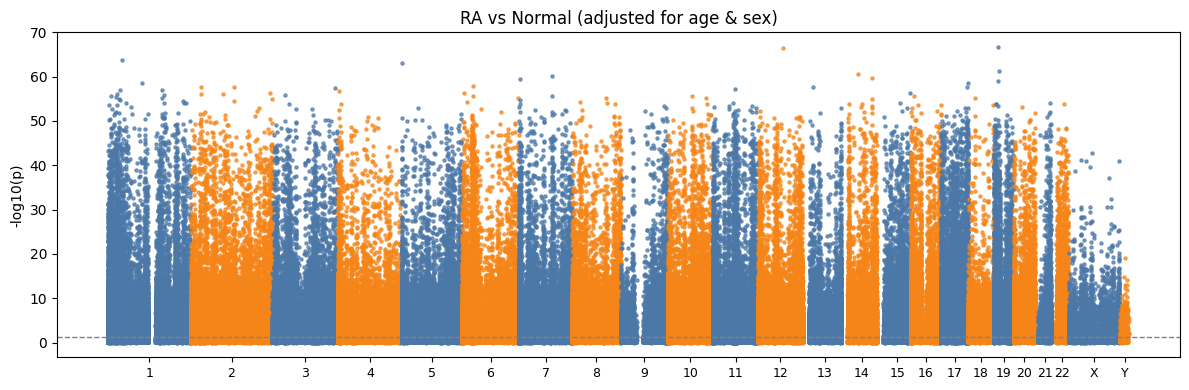

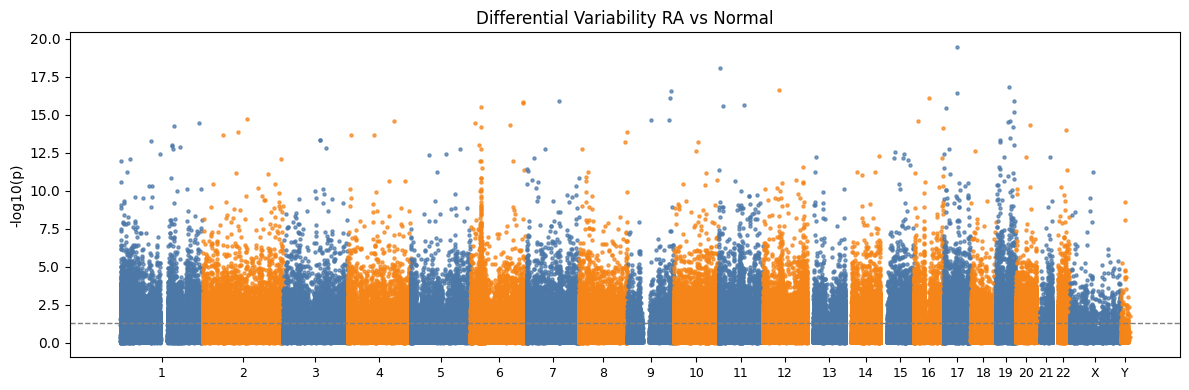

In [9]:
manhattan(res, pcol="p_RA", title="RA vs Normal (adjusted for age & sex)")
manhattan(res, pcol="p_DV", title="Differential Variability RA vs Normal")

## Results

In [10]:
top_ra = res.sort_values("p_RA").head(20)[
    ["CpG", "gene", "chrom", "pos", "p_RA", "q_RA"]
]
top_dv = res.sort_values("p_DV").head(20)[
    ["CpG", "gene", "chrom", "pos", "p_DV", "q_DV"]
]

print("Top 20 RA-associated CpGs:")
display(top_ra)
print("-" * 100)
print("Top 20 DV-associated CpGs:")
display(top_dv)

Top 20 RA-associated CpGs:


,CpG,gene,chrom,pos,p_RA,q_RA
403939,cg22898082,SMARCA4;SMARCA4;SMARCA4,19,11074428.0,2.143230e-67,9.157856e-62
457880,cg26244575,NaN,12,76354015.0,3.771948e-67,9.157856e-62
20393,cg00970057,HIVEP3;HIVEP3,1,42272694.0,1.517151e-64,2.455645e-59
55806,cg02739870,SLC12A7,5,1113320.0,8.651359e-64,1.050225e-58
54388,cg02668248,KLF2,19,16437789.0,5.803734e-62,5.636320e-57
405463,cg22991506,C14orf182,14,50468241.0,2.064710e-61,1.670959e-56
3312,cg00147751,GATS;GATS;GATS;GATS;PVRIG,7,99818709.0,9.130537e-61,6.333684e-56
242725,cg13152690,NaN,14,91695017.0,2.536015e-60,1.539288e-55
256118,cg13844341,MAD1L1;MAD1L1;MAD1L1,7,2116368.0,3.043961e-60,1.642308e-55
161365,cg08315613,SMARCA4;SMARCA4;SMARCA4,19,11074303.0,8.778989e-60,4.262875e-55


----------------------------------------------------------------------------------------------------
Top 20 DV-associated CpGs:


,CpG,gene,chrom,pos,p_DV,q_DV
293791,cg15944824,NaN,17,40981088.0,3.572703e-20,1.734823e-14
433393,cg24702253,MRGPRG;C11orf36,11,3240068.0,8.338667e-19,2.024533e-13
85466,cg04254389,NaN,19,40027263.0,1.523672e-17,2.466200e-12
202953,cg10701847,FAM113B,12,47626844.0,2.447093e-17,2.847846e-12
267480,cg14390764,PTGES,9,132516560.0,2.932435e-17,2.847846e-12
446077,cg25492458,DHX8,17,41564846.0,3.535554e-17,2.861306e-12
255290,cg13800700,NaN,9,128774824.0,7.648054e-17,4.884964e-12
175158,cg09107055,C16orf87,16,46854830.0,8.048098e-17,4.884964e-12
258304,cg13948710,ZNF813,19,53970754.0,1.198112e-16,6.034305e-12
166206,cg08593252,NaN,7,99198176.0,1.257205e-16,6.034305e-12
